In [1]:
# Crypto heatmap

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('ggplot')
%matplotlib inline

In [3]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Coinbase"
f = requests.get(url)
ipdata = f.json()
pd.DataFrame(ipdata['Data']).head(5)

,time,close,high,low,open,volumefrom,volumeto
0,1572912000,9322.09,9474.89,9169.84,9412.53,7370.45,6.880124e+07
1,1572998400,9341.27,9450.00,9253.66,9322.09,6804.27,6.351157e+07
2,1573084800,9198.84,9375.16,9075.00,9341.27,5750.11,5.302495e+07
3,1573171200,8763.01,9246.00,8660.00,9198.84,11993.34,1.066368e+08
4,1573257600,8807.89,8873.48,8712.52,8763.01,4175.01,3.672644e+07


In [4]:
def get_data(date):
    """query API for 2000 days historical price data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(
        date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [20]:
def get_df(from_date, to_date):
    date = to_date
    holder = []
    # while earliest date returned is later than the earliest data requested, keep querying API # and adding results to list
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
        # join together all api queries from list
        df = pd.concat(holder, axis=0)
        # remove data points from before from_date
        df = df[df['time'] > from_date]
        # convert to timestamp
        df['time'] = pd.to_datetime(df['time'], unit='s')
        return df

In [21]:
df_sept = get_df(1567296000, 1569801600)
df_oct = get_df(1569888000, 1572480000)
df_nov = get_df(1572566400, 1573848074)

df_sept_a = df_sept[['close', 'time']]
df_oct_a = df_oct[['close', 'time']]
df_nov_a = df_nov[['close', 'time']]

df_sept_a.tail()

,close,time
1996,8074.99,2019-09-26
1997,8201.36,2019-09-27
1998,8223.65,2019-09-28
1999,8065.26,2019-09-29
2000,8314.62,2019-09-30


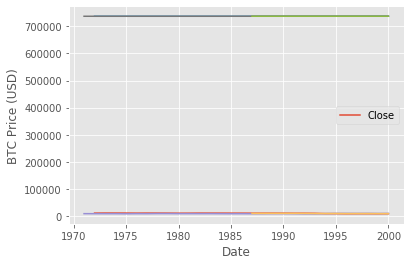

In [22]:
plt.plot(df_sept_a)
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.legend(['Close'])

plt.plot(df_oct_a)

plt.plot(df_nov_a)
plt.show()